# ISB-CGC Community Notebooks

Check out more notebooks at our [Community Notebooks Repository](https://github.com/isb-cgc/Community-Notebooks)!

```
Title:   Gene Set Scoring using hg38 mutation tables
Author:  Lauren Hagen
Created: 2019-07-22
Purpose: To demonstrate how to join two tables in BigQuery to compare the expression of a set of genes  between two groups.
URL:     https://github.com/isb-cgc/Community-Notebooks/blob/master/Notebooks/How_to_score_gene_sets_with_BigQuery.ipynb
Notes:   This notebook was adapted from work by David l Gibbs, January 2018 Query of the Month.
```
***

In this notebook, we’re going to implement a common bioinformatics task: gene set scoring. In this procedure, we will compare the *joint* expression of a set of genes between two groups.

Gene sets frequently result from experiments in which, for example, an expression is compared between two groups (e.g. control and treatment), and the genes that are significantly differentially expressed between the two groups form the “gene set”. Given a gene set, numerous approaches have been proposed to assign functional interpretations to a particular list of genes.

A related approach is to consider pathways as gene sets: each gene set will, therefore, be a canonical representation of a biological process compiled by domain experts. We will use the [WikiPathways](https://www.wikipathways.org/index.php/Download_Pathways) gene sets that have been previously assembled and stored in BigQuery. In total there were 381 pathways downloaded from WikiPathways. In the BQ table, each row contains a pathway and a gene associated with that pathway.

Our task will be to determine which genesets are differentially expressed when comparing two groups of samples. We will define groups of samples using the new hg38 Somatic Mutations table from the NCI Genomic Data Commons.

The BigQuery table at ISB-CGC is found at: isb-cgc.TCGA_hg38_data_v0.Somatic_Mutation_DR10

The BigQuery pathway table is found at: isb-cgc.QotM.WikiPathways_20170425_Annotated

We will implement a method found in a paper titled “Gene set enrichment analysis made simple” (Rafael A Irrazary et al, PMID 20048385). They propose a simple solution that outperforms a popular and more complex method known as GSEA.

In short, (I’ll explain later), the gene set score comes from an average of T-tests, where the T-statistics come from testing each gene for differential expression between the two groups. The statistic is then weighted by the square root of the sample size (number of genes in the set), so that with larger gene sets, the ‘significant’ effect size can get pretty small.

At the end of it, the full query processes 29.8GB in 10.1s and costs ~$0.15.

First, we will need to import bigquery module, autheticate ourselves, and create a client variable. For more information see ['Quick Start Guide to ISB-CGC'](INSERT LINK) and alternative authentication methods can be found [here](https://googleapis.github.io/google-cloud-python/latest/core/auth.html).

In [ ]:
# Import BigQuery Module
from google.cloud import bigquery

In [ ]:
# Autheticate ourselves
!gcloud auth application-default login

In [ ]:
# Create a variable for which client to use with BigQuery
project_num = 'your_project_number'# Replace with your project ID
if project_num == 'your_project_number':
    print('Please update the project number with your Google Cloud Project')
else:
    client = bigquery.Client(project) 

Let’s get started on creating the full query. First, which tissue type should we focus on? Let’s choose PARP1 as an interesting gene – it encodes an enzyme involved in DNA damage repair and is also the target of some therapeutic drugs – and use the Somatic Mutation table to choose a cancer type:

** Note: you will need to update 'your_project_number' with your project number before continuing with the notebook **

In [ ]:
# Magic command of bigquery with the project id as your project number and create a Pandas Dataframe
# Change your_project_number to your project ID
%%bigquery --project your_project_number
SELECT
  project_short_name,
  COUNT(DISTINCT(sample_barcode_tumor)) AS n
FROM
  `isb-cgc.TCGA_hg38_data_v0.Somatic_Mutation_DR10`
WHERE
  Hugo_Symbol = 'PARP1'
GROUP BY
  project_short_name
ORDER BY
  n DESC

,project_short_name,n
0,TCGA-UCEC,46
1,TCGA-COAD,22
2,TCGA-STAD,22
3,TCGA-BRCA,17
4,TCGA-SKCM,16
5,TCGA-BLCA,15
6,TCGA-LUSC,12
7,TCGA-CESC,9
8,TCGA-GBM,8
9,TCGA-LUAD,6


The result of that query shows that 46 tumor samples have PARP1 mutations in UCEC, followed by COAD and STAD with 22 each. That’s a big lead by UCEC, so let’s focus our work there.

Here’s where our main query will begin. Since this is standard SQL, we’ll be naming each subtable, and the full query can be constructed by concatenating each of the following sub-queries. Many of the code lines that run the query at each step will be marked with '%%script false' so that extra queries are not charged.

In [ ]:
# Create a variable for the first subquery
# This subquery will return sample barcodes with at least one known somatic mutation
s1 = """
WITH
s1 AS (
  SELECT
    sample_barcode_tumor AS sample_barcode
  FROM
    `isb-cgc.TCGA_hg38_data_v0.Somatic_Mutation_DR10`
  WHERE
    project_short_name = 'TCGA-UCEC'
  GROUP BY
    1
)
"""
# Create a variable to return the values from the first subquery
query1 = s1 + "SELECT * FROM s1"

In [ ]:
%%script false
# Run the subquery 
s1_df = client.query(query1).to_dataframe()
# Print the number of rows in the dataframe
len(s1_df)

This query returns 530 tumor sample barcodes with at least one known somatic mutation. (The TCGA Biospecimen table includes information for a total of 553 UCEC tumor samples, but some may have not been sequenced or may have no somatic mutations – the former being more likely than the latter.) Recall that somatic mutations are variants in the DNA that are found when comparing the tumor sequence to the ‘matched normal’ sequence (typically from a blood sample, but sometimes from adjacent tissue). Next, for all these samples, we’ll want to restrict our analysis to samples for which we also have mRNA expression data:

In [ ]:
sampleGroup = """
sampleGroup AS (
  SELECT
    sample_barcode
  FROM
    `isb-cgc.TCGA_hg38_data_v0.RNAseq_Gene_Expression`
  WHERE
    project_short_name = 'TCGA-UCEC'
    AND sample_barcode IN
    (select sample_barcode from s1)
  GROUP BY
    1
)"""
# Combine previous subquery with sampleGroup
query2 = s1 + "," + sampleGroup + "SELECT * FROM sampleGroup"

In [ ]:
%%script false
# Run the query2 subquery 
sampleGroup_df = client.query(query2).to_dataframe()
# Print the number of rows in the dataframe
len(sampleGroup_df)

Now we have 526 samples for which we have gene expression and somatic mutation calls. We are interested in partitioning this group into two parts: one with a mutation of interest, and one without. So let’s gather barcodes for tumors with non-silent mutations in PARP1.

In [ ]:
groups = """
--
-- The first group has non-synonymous mutations in PARP1
--
grp1 AS (
  SELECT
    sample_barcode_tumor AS sample_barcode
  FROM
    `isb-cgc.TCGA_hg38_data_v0.Somatic_Mutation_DR10`
  WHERE
    Hugo_Symbol = 'PARP1'
    AND One_Consequence <> 'synonymous_variant'
    AND sample_barcode_tumor IN (
      SELECT
        sample_barcode
      FROM
        sampleGroup )
    GROUP BY sample_barcode
  ),
--
-- group 2 is the rest of the samples
--
grp2 AS (
  SELECT
    sample_barcode
  FROM
    sampleGroup
  WHERE
    sample_barcode NOT IN (
      SELECT
        sample_barcode
      FROM
        grp1)
)
"""
query3_grp1 = s1 + "," + sampleGroup + "," + groups + "SELECT * FROM grp1"
query3_grp2 = s1 + "," + sampleGroup + "," + groups + "SELECT * FROM grp2"

In [ ]:
%%script false
# Run the query3 subquery 
grp1_df = client.query(query3_grp1).to_dataframe()
# Print the number of rows in the dataframe
len(grp1_df)

In [ ]:
%%script false
# Run the query4 subquery 
grp2_df = client.query(query3_grp2).to_dataframe()
# Print the number of rows in the dataframe
len(grp2_df)

This results in 41 tumor samples with non-synonymous PARP1 variants and 485 samples without.

Next we’re going to summarize the gene expression within each of these groups. This will be used for calulating T-statistics in the following portion of the query we are constructing. For each gene, we’ll take the mean, variance, and count of samples.

In [ ]:
summaries = """
-- Summaries for Group 1 (with mutation)
--
summaryGrp1 AS (
  select
    gene_name as symbol,
    AVG(LOG10( HTSeq__FPKM_UQ +1)) as genemean,
    VAR_SAMP(LOG10( HTSeq__FPKM_UQ +1)) as genevar,
    count(sample_barcode) as genen
  FROM
    `isb-cgc.TCGA_hg38_data_v0.RNAseq_Gene_Expression`
  WHERE
    sample_barcode IN (select sample_barcode FROM grp1)
    AND gene_name IN (
      SELECT
        Symbol as gene_name
      FROM
        `isb-cgc.QotM.WikiPathways_20170425_Annotated`
    )
  GROUP BY
    gene_name
),
--
-- Summaries for Group 2 (without mutation)
--
summaryGrp2 AS (
  select
    gene_name as symbol,
    AVG(LOG10( HTSeq__FPKM_UQ +1)) as genemean,
    VAR_SAMP(LOG10( HTSeq__FPKM_UQ +1)) as genevar,
    count(sample_barcode) as genen
  FROM
    `isb-cgc.TCGA_hg38_data_v0.RNAseq_Gene_Expression`
  WHERE
    sample_barcode IN (select sample_barcode FROM grp2)
    AND gene_name IN (
      SELECT
        Symbol as gene_name
      FROM
        `isb-cgc.QotM.WikiPathways_20170425_Annotated`
    )
  GROUP BY
    gene_name
)
--
"""
query4_grp1 = s1 + "," + sampleGroup + "," + groups + "," + summaries + "SELECT * FROM summaryGrp1"
query4_grp2 = s1 + "," + sampleGroup + "," + groups + "," + summaries + "SELECT * FROM summaryGrp2"

In [ ]:
%%script false
# Run the query5 subquery 
summaryGrp1_df = client.query(query4_grp1).to_dataframe()
# Print the number of rows in the dataframe
len(summaryGrp1_df)

6505

In [ ]:
%%script false
# Run the query6 subquery 
summaryGrp2_df = client.query(query4_grp2).to_dataframe()
# Print the number of rows in the dataframe
len(summaryGrp2_df)

This results in two sets of summaries for 4,822 genes. (There are 4,962 unique gene symbols in the WikiPathways table, but 140 of them do not match any of the symbols in the TCGA hg38 expression table.) With this, we are ready to calculate T-statistics. Here we’re going to use a two sample T-test assuming independent variance (and that we have enough samples to assume that). The T-statistic is found by taking the difference in means (of gene expression between our two groups), and normalizing it by measures of variance and sample size. Here, we want to keep T-statistics that are zero, which might come from having zero variance, because having a T-stat for each gene is important in the gene set score, even if it’s a zero. To do that, you’ll see the use of an IF statement below.

In [ ]:
tStatsPerGene = """
tStatsPerGene AS (
SELECT
  grp1.symbol as symbol,
  grp1.genen as grp1_n,
  grp2.genen AS grp2_n,
  grp1.genemean AS grp1_mean,
  grp2.genemean AS grp2_mean,
  grp1.genemean - grp2.genemean as meandiff,
  IF ((grp1.genevar > 0
       AND grp2.genevar > 0
       AND grp1.genen > 0
       AND grp2.genen > 0),
    (grp1.genemean - grp2.genemean) / SQRT( (POW(grp1.genevar,2)/grp1.genen)+ (POW(grp2.genevar,2)/grp2.genen) ),
    0.0) AS tstat
FROM
  summaryGrp1 as grp1
  JOIN
  summaryGrp2 AS grp2
  ON
  grp1.symbol = grp2.symbol
GROUP BY
  grp1.symbol,
  grp1.genemean,
  grp2.genemean,
  grp1.genevar,
  grp2.genevar,
  grp1.genen,
  grp2.genen
)
"""
query5 = s1 + "," + sampleGroup + "," + groups + "," + summaries + "," + tStatsPerGene + "SELECT * FROM tStatsPerGene"

In [ ]:
# Run the query5 subquery 
tStatsPerGene_df = client.query(query5).to_dataframe()
tStatsPerGene_df.head()

,symbol,grp1_n,grp2_n,grp1_mean,grp2_mean,meandiff,tstat
0,OR2H2,41,489,0.939560,1.560230,-0.620669,-1.678449
1,AKR1C2,41,489,3.560256,3.648247,-0.087991,-0.223780
2,PRKAA2,41,489,4.282969,4.369887,-0.086918,-2.168308
3,B4GALT1,41,489,6.273455,6.323255,-0.049801,-3.030482
4,ETF1,41,489,5.787471,5.726543,0.060928,24.259761


We are now going plot the t-statistic using [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/) with [numpy](https://numpy.org/) and [pandas](https://pandas.pydata.org/).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

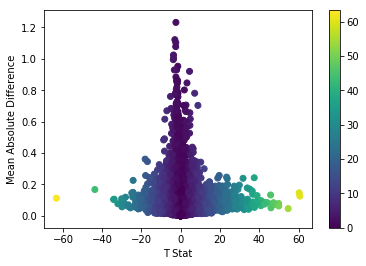

In [ ]:
# Set x as the t statistic for each gene
x1 = tStatsPerGene_df.tstat
# Set y as the absolute value of the mean difference
y1 = abs(tStatsPerGene_df.meandiff)
# Set the color of the dots of the absolute value of the t statistic 
color = abs(tStatsPerGene_df.tstat)
# Create the scatter plot
plt.scatter(x1,y1,c=color)
# Add a legend for the colors
plt.colorbar()
# Add labels
plt.xlabel('T Stat')
plt.ylabel('Mean Absolute Difference')
# Display the scatter plot
plt.show()

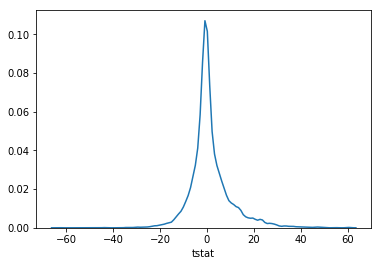

In [ ]:
# Create a Density Plot of the Data 
sns.distplot(x1, hist=False, kde=True)

OK! We have a distribution of T statistics. The question is whether there’s some hidden structure to these values. Are there gene sets with unusually high T-statistics? And do these gene sets make any sort of biological sense? Let’s find out!

Now we are going to integrate our gene set table. This is as easy as doing a table join.

In [ ]:
geneSetTable = """geneSetTable AS (
SELECT
  gs.pathway,
  gs.wikiID,
  gs.Symbol,
  st.grp1_n,
  st.grp2_n,
  st.grp1_mean,
  st.grp2_mean,
  st.meandiff,
  st.tstat
FROM
  `isb-cgc.QotM.WikiPathways_20170425_Annotated` as gs
JOIN
  tStatsPerGene as st
ON
  st.symbol = gs.symbol
GROUP BY
  gs.pathway,
  gs.wikiID,
  gs.Symbol,
  st.grp1_n,
  st.grp2_n,
  st.grp1_mean,
  st.grp2_mean,
  st.meandiff,
  st.tstat
)
"""
query6 = s1 + "," + sampleGroup + "," + groups + "," + summaries + "," + tStatsPerGene + "," + geneSetTable + "SELECT * FROM geneSetTable"

In [ ]:
%%script false
# Run the query6 subquery 
geneSetTable_df = client.query(query6).to_dataframe()
geneSetTable_df.head()

That’s it! For each gene in the pathways (gene sets) table, we have joined in the T-statistic comparing our two groups. Now for the gene set score! To get this, we’re going to simply average over the T’s within each pathway, and scale the result by the square root of the number of genes. When the number of genes gets large (reasonably so), the value approximates a Z-score. In this way, using R for example, we could get a p-value and perform multiple testing correction in order to control the false discovery rate.

In [ ]:
geneSetScores = """geneSetScores AS (
SELECT
  pathway,
  wikiID,
  COUNT(symbol) AS n_genes,
  AVG(ABS(meandiff)) AS avgAbsDiff,
  (SQRT(COUNT(symbol))/COUNT(symbol)) * SUM(tstat) AS score
FROM
  geneSetTable
GROUP BY
  pathway,
  wikiID )
--
--
SELECT
  *
FROM
  geneSetScores
ORDER BY
  score DESC """
query7 = s1 + "," + sampleGroup + "," + groups + "," + summaries + "," + tStatsPerGene + "," + geneSetTable + "," + geneSetScores

In [ ]:
# Run the query9 subquery 
geneSetScores = client.query(query7).to_dataframe()
geneSetScores.head()

,pathway,wikiID,n_genes,avgAbsDiff,score
0,Retinoblastoma (RB) in Cancer,WikiPathways_20170410,85,0.090741,100.586657
1,DNA Replication,WikiPathways_20170410,41,0.096387,87.290089
2,Cell Cycle,WikiPathways_20170410,98,0.080785,62.985939
3,Eukaryotic Transcription Initiation,WikiPathways_20170410,37,0.046662,55.004553
4,Glycolysis and Gluconeogenesis,WikiPathways_20170410,48,0.130570,54.367318


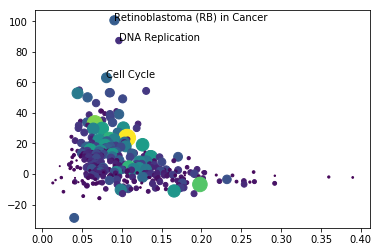

In [ ]:
x2 = geneSetScores.avgAbsDiff
y2 = geneSetScores.score
s = geneSetScores.n_genes
plt.annotate(geneSetScores.iloc[0,0],[geneSetScores.iloc[0,3],geneSetScores.iloc[0,4]])
plt.annotate(geneSetScores.iloc[1,0],[geneSetScores.iloc[1,3],geneSetScores.iloc[1,4]])
plt.annotate(geneSetScores.iloc[2,0],[geneSetScores.iloc[2,3],geneSetScores.iloc[2,4]])
plt.scatter(x2,y2,s,c=s)

So, we see that ‘Retinoblastoma (RB) in Cancer’ is in the top spot with a score way above the #2 position. Why might that be? Well, PARP1 is involved in DNA damage repair, specifically through the non-homologous endjoining (NHEJ) mechanism. Samples that are deficient in PARP1 are going to have a hard time repairing DNA breaks, which makes cancer more likely. So, RB1 might need to take up the slack, and indeed it’s known as a ‘tumor suppressor protein’: when DNA is damaged, the cell cycle needs to freeze, which happens to be one of RB1’s special tricks, and also probably why we see the next two top ranked pathways ‘DNA Replication’ and ‘Cell Cycle’.

For more on this topic see:

* Retinoblastoma (RB) in Cancer (Homo sapiens) ([Wiki pathway WP2446](https://www.wikipathways.org/index.php/Pathway:WP2446))
* RB1 gene ([Wikipedia entry](https://en.wikipedia.org/wiki/Retinoblastoma_protein))
* Direct involvement of retinoblastoma family proteins in DNA repair by non-homologous end-joining. ([Cook et al, 2015](https://www.ncbi.nlm.nih.gov/pubmed/25818292))

The full query is written below and called upon with the BigQuery python magic command to ease the readablity of the SQL. It has been set not to run to save money by not running the same query a second time.

In [ ]:
%%script false
%%bigquery final_query --project your_project_number
WITH
s1 AS (
  SELECT
    sample_barcode_tumor AS sample_barcode
  FROM
    `isb-cgc.TCGA_hg38_data_v0.Somatic_Mutation_DR10`
  WHERE
    project_short_name = 'TCGA-UCEC'
  GROUP BY
    1
),
---
sampleGroup AS (
SELECT
  sample_barcode
FROM
  `isb-cgc.TCGA_hg38_data_v0.RNAseq_Gene_Expression`
WHERE
  project_short_name = 'TCGA-UCEC'
  AND sample_barcode IN
  (select sample_barcode from s1)
GROUP BY
  1 
),
--
-- The first group has non-synonymous mutations in PARP1
--
grp1 AS (
SELECT
  sample_barcode_tumor AS sample_barcode
FROM
  `isb-cgc.TCGA_hg38_data_v0.Somatic_Mutation_DR10`
WHERE
  Hugo_Symbol = 'PARP1'
  AND One_Consequence <> 'synonymous_variant'
  AND sample_barcode_tumor IN (
    SELECT
      sample_barcode
    FROM
      sampleGroup )
  GROUP BY sample_barcode
),
--
-- group 2 is the rest of the samples
--
grp2 AS (
SELECT
  sample_barcode
FROM
  sampleGroup
WHERE
  sample_barcode NOT IN (
    SELECT
      sample_barcode
    FROM
      grp1)
),
---
-- Summaries for Group 1 (with mutation)
--
summaryGrp1 AS (
  select
    gene_name as symbol,
    AVG(LOG10( HTSeq__FPKM_UQ +1)) as genemean,
    VAR_SAMP(LOG10( HTSeq__FPKM_UQ +1)) as genevar,
    count(sample_barcode) as genen
  FROM
    `isb-cgc.TCGA_hg38_data_v0.RNAseq_Gene_Expression`
  WHERE
    sample_barcode IN (select sample_barcode FROM grp1)
    AND gene_name IN (
      SELECT
        Symbol as gene_name
      FROM
        `isb-cgc.QotM.WikiPathways_20170425_Annotated`
    )
  GROUP BY
    gene_name
),
--
-- Summaries for Group 2 (without mutation)
--
summaryGrp2 AS (
  select
    gene_name as symbol,
    AVG(LOG10( HTSeq__FPKM_UQ +1)) as genemean,
    VAR_SAMP(LOG10( HTSeq__FPKM_UQ +1)) as genevar,
    count(sample_barcode) as genen
  FROM
    `isb-cgc.TCGA_hg38_data_v0.RNAseq_Gene_Expression`
  WHERE
    sample_barcode IN (select sample_barcode FROM grp2)
    AND gene_name IN (
      SELECT
        Symbol as gene_name
      FROM
        `isb-cgc.QotM.WikiPathways_20170425_Annotated`
    )
  GROUP BY
    gene_name
),
---
tStatsPerGene AS (
SELECT
  grp1.symbol as symbol,
  grp1.genen as grp1_n,
  grp2.genen AS grp2_n,
  grp1.genemean AS grp1_mean,
  grp2.genemean AS grp2_mean,
  grp1.genemean - grp2.genemean as meandiff,
  IF ((grp1.genevar > 0
       AND grp2.genevar > 0
       AND grp1.genen > 0
       AND grp2.genen > 0),
    (grp1.genemean - grp2.genemean) / SQRT( (POW(grp1.genevar,2)/grp1.genen)+ (POW(grp2.genevar,2)/grp2.genen) ),
    0.0) AS tstat
FROM
  summaryGrp1 as grp1
  JOIN
  summaryGrp2 AS grp2
  ON
  grp1.symbol = grp2.symbol
GROUP BY
  grp1.symbol,
  grp1.genemean,
  grp2.genemean,
  grp1.genevar,
  grp2.genevar,
  grp1.genen,
  grp2.genen
),
---
geneSetTable AS (
SELECT
  gs.pathway,
  gs.wikiID,
  gs.Symbol,
  st.grp1_n,
  st.grp2_n,
  st.grp1_mean,
  st.grp2_mean,
  st.meandiff,
  st.tstat
FROM
  `isb-cgc.QotM.WikiPathways_20170425_Annotated` as gs
JOIN
  tStatsPerGene as st
ON
  st.symbol = gs.symbol
GROUP BY
  gs.pathway,
  gs.wikiID,
  gs.Symbol,
  st.grp1_n,
  st.grp2_n,
  st.grp1_mean,
  st.grp2_mean,
  st.meandiff,
  st.tstat
),
---
geneSetScores AS (
SELECT
  pathway,
  wikiID,
  COUNT(symbol) AS n_genes,
  AVG(ABS(meandiff)) AS avgAbsDiff,
  (SQRT(COUNT(symbol))/COUNT(symbol)) * SUM(tstat) AS score
FROM
  geneSetTable
GROUP BY
  pathway,
  wikiID )
--
--
SELECT
  *
FROM
  geneSetScores
ORDER BY
  score DESC

In [ ]:
%%script false
final_query.head()